## A differentiable probabilistic model of cryogenic electron microscopy

In this tutorial, we demonstrate how to load a protein model in .mrc format, apply the differntiable backprojection-operator to it, and use the generative model to learn a latent distribution.

For this, first, we load essential libraries and specify the cuda input device.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import pickle
import torch
from torch import distributions
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from observation_model import ScientificImagingObservationModel

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

We next load the GroEL-GroES protein [1]. Note that for this we use some third party code [2]. 
We configure the total mass "total_mass" of the protein and the extent of the observations $D$ manually.

In [2]:
from third_party import readMRC, compute_premultiplier, real_to_fspace, window, fspace_to_real


def load_protein(path, total_mass, D):
    M = readMRC(path)
    kernel = 'linear'
    ksize = 2
    premult = compute_premultiplier(D, kernel, ksize)
    premult = premult.reshape((1, 1, -1)) * premult.reshape((1, -1, 1)) * premult.reshape((-1, 1, 1))
    window(M, 'circle')
    M[M < 0] = 0
    if total_mass is not None:
        M *= float(total_mass) / M.sum()
    structure = real_to_fspace(M * premult)
    structure = np.concatenate((np.array(structure.real, ndmin=4).T, np.array(structure.imag, ndmin=4).T), axis=3)
    return torch.tensor(structure).unsqueeze(0).permute(0, 4, 1, 2, 3)


D = 128
protein = load_protein(path="./proteins/1AON.mrc", total_mass=80000, D=D).to(device)

ERROR LOADING FFTW! USING NUMPY


### Appying the differentiable backprojection-operator
We next specify some random position and project the protein constrain to this poition:

In [3]:
# generate random position
from operators import rotmat3D_EA

rotation = torch.rand((1, 3)).to(device)
rotation_representation = rotmat3D_EA(rotation)
translation = torch.rand((1, 2)).to(device) * 0.2

# load observation model
from observation_model import ScientificImagingObservationModel

observation_model = ScientificImagingObservationModel(D=D, std_noise=0.).to(device)

# get projection
projection, _ = observation_model(protein, rotation_representation, translation)


/home/karen/devtools/miniconda2/envs/backprojection/lib/python3.6/site-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Finally lets look at the projections, in real and fourier space. Note how, the reconstructions imaginary part is not exactly zero. This is due to nummerical errors.

These are the projections in the Fourier domain (log-scaled for better visability).
 Real:


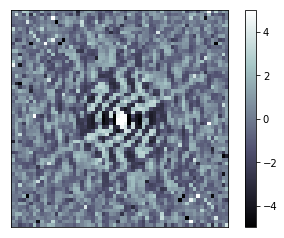

And imaginary part:


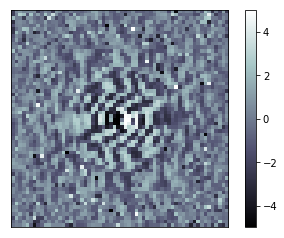

Transforming them back to real space, leads to,
Real part (signal):


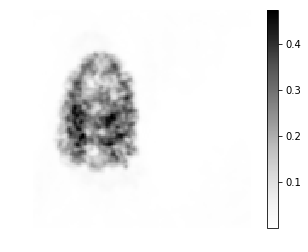

Imaginary part (This should be zero):


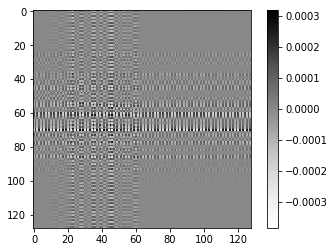

In [4]:
import utils

print("These are the projections in the Fourier domain (log-scaled for better visability).\n Real:")
utils.plot_fourier(projection[0, 0], name="projection_real", logsclae=True, vmax=5, vmin=-5, centercrop=30, save=False)
print("And imaginary part:")
utils.plot_fourier(projection[0, 1], name="projection_real", logsclae=True, vmax=5, vmin=-5, centercrop=30, save=False)
print("Transforming them back to real space, leads to,")
utils.plot_fourier2real(projection, name="real_transforms", save=False)

### Training a generative model

In the second part of this tutorial, we shall train a simple model.
 
First, we demonstrate how to load a dataset. The dataset itself has been generated witht he code provided in [2]. The SNR of observations is at 0.04. Be advised to use the  pytorch specific class to load a dataset for any larger tasks since this can easily exceed cpu memory.

In [5]:
def load_dataset(path):
    observations, rotation_representations, translations = [], [], []
    
    images = readMRC(path)
    images = np.transpose(images, axes=[2, 0, 1])
    
    with open(path.replace('imgdata.mrc','pardata.pkl'),'rb') as fp:
        pardata = pickle.load(fp, encoding='latin1')

    for index, img in enumerate(images):
        img = real_to_fspace(img)
        img_real = np.expand_dims(img.real, 0)
        img_imag = np.expand_dims(img.imag, 0)
        observations.append(np.vstack([img_real, img_imag]))
        rotation_representations.append(np.expand_dims(pardata['EA'][index],0))
        translations.append(np.expand_dims(pardata['t'][index],0))

    observations = torch.Tensor(np.stack(observations)).to(device)
    rotation_representations = torch.Tensor(np.stack(rotation_representations)).to(device)
    translations = torch.Tensor(np.stack(translations)).to(device)
    return observations, rotation_representations, translations

observations, rotation_representations, translations = load_dataset("./datasets/1AON_1000/imgdata.mrc")
num_data_points = observations.shape[0]

Nex, we initalise the parameters for the posterior distribution of the protein density. Note, that for a better posterior it is wise to restrict the posterior distribution to real real domain signals as we have done in our paper.

In [6]:
protein_loc = nn.Parameter(torch.Tensor(2, D, D, D).to(device), requires_grad=True)
protein_log_scale = nn.Parameter(torch.Tensor(2, D, D, D).to(device), requires_grad=True)

# init params
protein_loc.data.fill_(0.)
protein_log_scale.data.fill_(-100)

print()

Finally, we can train the model based on the observations.

In [7]:
num_iterations = int(2e3)


def optimizer_grad_step(optimizer):
    for opt in optimizer:
        opt.step()
        opt.zero_grad()
    return optimizer


optimizer = []
optimizer.append(optim.Adam([protein_loc], lr=.1, betas=(0.8, 0.999)))
optimizer.append(optim.Adam([protein_log_scale], lr=0.01, betas=(0.8, 0.999)))


# we ignore pixels that lay out of the niquist frequency
def create_radial_mask(shape, radius=None):
    N = shape[0]
    radius -= 1.
    if radius < 0.:
        return np.zeros(shape) * 1.0

    elif radius is None:
        radius = int(N / 2)

    a, b = N / 2, N / 2
    y, x = np.ogrid[-a:N - a, -b:N - b]
    mask = x * x + y * y <= radius * radius

    return mask * np.ones(shape) * 1.0

mask = torch.Tensor(create_radial_mask((D, D), int(D / 2))).to(device)
num_pixels = mask.sum()

error = 0.
for iteration in range(num_iterations):
    idx = random.randint(0, num_data_points)
    protein_dist = distributions.Normal(loc=protein_loc, scale=F.softplus(protein_log_scale))
    protein_sample = protein_dist.rsample((1,))
    
    t = translations[idx] / D
    R = rotmat3D_EA(rotation_representations[idx] / 180.0 * np.pi)        
    
    projection, observation_dist = observation_model(protein_sample, R, t)

    conditional_loglikelihood = observation_dist.log_prob(observations[idx].unsqueeze(0)).sum() / num_pixels
    loss = -conditional_loglikelihood
    loss.backward()
    optimizer_grad_step(optimizer)

    # compare learned volume to data generating one
    error += loss.detach().cpu().numpy()
    print("Iteration {}/{}, error: {:.3f}".format(iteration, num_iterations, error/(iteration+1.)), end='\r', flush=True)

Let's check if we learned something that resembles a protein. By looking at some random projection. 

Real part (signal):


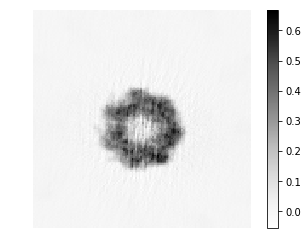

Imaginary part (This should be zero):


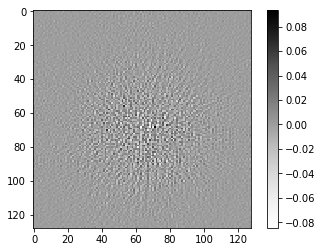

In [8]:
projection, _ = observation_model(protein_loc.unsqueeze(0), R, t)
utils.plot_fourier2real(projection,name="", save=False)

To visualize the results of ones fit we recommend using the ChimeraX software.
Below we display a recorded example.

In [9]:
import io
import base64
from IPython.display import HTML

video = io.open('chimeraX_vis.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

References:

*    [1] Xu, Z., Horwich, A. L., and Sigler, P. B. (1997). The crystal structure of the asymmetric groel–groes–
(adp) 7 chaperonin complex. Nature, 388(6644):741.

*    [2] https://github.com/mbrubake/cryoem-cvpr2015